# 中文语料库的使用

In [1]:
coding='utf-8'
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba # 结巴分词
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('chinese_word_vectors/sgns.zhihu.bigram', 
                                          binary=False)

#### 什么是embedding

地图就是对于现实地理的embedding，现实的地理地形的信息其实远远超过三维 但是地图通过颜色和等高线等来最大化表现现实的地理信息。

词的embedding也就是用固定的维度来最大化表现词的信息

作用是把松散的one-hot字典表示法变为固定大小的向量，能方便的通过向量cos求得词语间是否近似

In [3]:
# 每一个词都对应一个长度为300的向量（300维）
embedding_dim = cn_model['你好'].shape[0]
print('词向量的长度为{}'.format(embedding_dim))
cn_model['你好']

词向量的长度为300


array([-1.839300e-02, -4.797640e-01, -1.115136e+00, -2.417000e-02,
        2.293440e-01, -8.419710e-01, -7.340420e-01,  1.342570e-01,
       -3.668080e-01, -7.464200e-02, -5.322120e-01,  2.076460e-01,
       -8.524420e-01, -7.274490e-01,  4.140000e-02, -1.320350e-01,
        3.192460e-01, -1.300115e+00, -2.239420e-01, -1.488940e-01,
       -2.176700e-02,  5.542770e-01, -1.617870e-01,  4.242610e-01,
        9.656400e-02, -8.644500e-02, -6.494450e-01, -2.400440e-01,
       -1.060745e+00, -3.220000e-02, -6.661110e-01,  4.554000e-03,
        8.424700e-02,  1.615070e-01,  1.908820e-01, -7.867680e-01,
       -7.221560e-01,  4.915430e-01, -3.853340e-01,  1.394420e-01,
       -2.067480e-01, -1.179910e-01,  4.989760e-01,  1.117296e+00,
        3.776300e-02, -5.642530e-01,  2.914660e-01, -1.017945e+00,
       -4.110000e-04, -1.349609e+00, -1.054234e+00, -5.482800e-01,
       -5.235040e-01, -1.695090e-01, -3.141680e-01,  2.332400e-02,
       -1.379530e-01,  1.586490e-01, -1.511060e-01,  7.714800e

In [7]:
# 相似度其实就是：dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ）
np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']), 
cn_model['橙子']/np.linalg.norm(cn_model['橙子']))

0.66128117

In [8]:
# 计算相似度
cn_model.similarity('橘子', '橙子')

0.66128117

In [7]:
cn_model.vocab['老师'].index

215

In [8]:
cn_model.index2word[215]

'老师'

In [9]:
# 找出最相近的词，余弦相似度
cn_model.most_similar(positive=['知道'], topn=10)

[('并不知道', 0.5925602912902832),
 ('不晓得', 0.5772397518157959),
 ('明白', 0.5554894804954529),
 ('不知', 0.5548974275588989),
 ('晓得', 0.5365551114082336),
 ('真不知道', 0.5153868794441223),
 ('知晓', 0.4782266914844513),
 ('天知道', 0.46890372037887573),
 ('了解到', 0.455231636762619),
 ('深知', 0.4438132047653198)]

In [10]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 老师 会计师 程序员 律师 医生 老人 中:
不是同一类别的词为: 老人


In [11]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=1)

[('劈腿', 0.5849199295043945)]

# 酒店评价分类

训练语料:


使用谭松波老师的酒店评论语料
训练样本分别被放置在两个文件夹里： 分别的pos和neg，每个文件夹里有2000个txt文件，每个文件内有一段评语，共有4000个训练样本，这样大小的样本数据在NLP中属于非常迷你的：

In [4]:
# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价
import os
pos_txts = os.listdir('pos')
neg_txts = os.listdir('neg')

In [7]:
print( '正面评价共: '+ str(len(pos_txts)) )
print('负面评价共：' + str(len(neg_txts)))

正面评价共: 1942
负面评价共：1911


### 我下到的语料库是乱码的，需要解决这个问题 

In [8]:
import chardet 
f = open('pos.5.txt','rb')
result = chardet.detect(f.read())
print(result)

{'encoding': 'GB2312', 'confidence': 0.99, 'language': 'Chinese'}


### 最终探明我的语料库是用GB2312编码的（不是ANSI），接下来把它转为utf-8格式则恢复正常 

最终没能实现notepad++批量转码，插件无法安装，这里还是需要探索。另外自己写脚本批量转码也没有成功，但下面这段批量转码可以正常操作

In [81]:
# ANSI文件转UTF-8
import codecs
import os
 
# 文件所在目录
file_path = "C:\\Users\\CaiTi\\neg"
files = os.listdir(file_path)
count = 0
 
for file in files:
    file_name = file_path + '\\' + file
    f = codecs.open(file_name, 'r', 'GB2312')
    try:
        ff = f.read()
        file_object = codecs.open(file_path + '\\' + file, 'w', 'utf-8')
        file_object.write(ff)
    except:
        pass
    

In [28]:
f = open('pos/pos.10.txt',encoding='utf-8')
ff = f.read()
print(ff)

早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。

房间本身很好。






In [82]:
# 现在我们将所有评价内容放入一个list里面

# 存储所有评价，每例评价为一条string
train_texts_orig = []

for i in range(len(pos_txts)):
    # 对2000个正评价循环，打开第i个文件
    with open('pos/'+pos_txts[i], encoding='utf-8', errors = 'ignore') as f:
        text = f.read().strip()
        # 在list中添加这条评价的string
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('neg/'+neg_txts[i],encoding='utf-8',errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
        

In [32]:
len(train_texts_orig)

3853

至此我们获得了***3853***条评价的list（4000条中有一部分在转码中损失掉了），接下来我们要导入所需类库，并做预处理

In [11]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

### 分词和tokenize


首先我们去掉每个样本的标点符号，然后用jieba分词，jieba分词返回一个生成器，没法直接进行tokenize，所以我们将分词结果转换成一个list，并将它索引化，这样每一例评价的文本变成一段索引数字，对应着预训练词向量模型中的词。

In [33]:
# 进行分词和tokenize

# train_tokens 是一个长长的list, 其中包含4000个小list，对应每一条评价
train_tokens = []

# 对上一步得到的4000句评价循环
for text in train_texts_orig:
    #去掉标点,(把text中的中文标点替换成空字符串)
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    #结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list(现在cut_list是一句话里每一个词语组成的list)
    cut_list = [i for i in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

#### 索引长度标准化

因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，这样十分浪费计算资源，所以我们取一个折衷的长度。

In [40]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

[23 86 16 ... 44 45  0]


In [35]:
# 平均tokens的长度
np.mean(num_tokens)

71.74305735790293

In [36]:
# 最长的评价tokens的长度
np.max(num_tokens)

1540

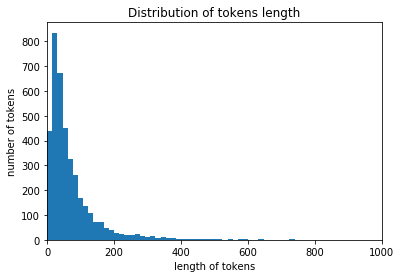

In [38]:
# 评价长度的分布
plt.hist(num_tokens, bins = 100)
plt.xlim((0,1000))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [41]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
# (取完log后会符合正态分布)， 但意义是什么
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

238

In [42]:
# 取tokens的长度为843时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9563976122501947

### 反向tokenize

我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。（reverse后会失去标点）

In [43]:
# 用来将tokens转换为文本

def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [44]:
reverse = reverse_tokens(train_tokens[0])
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [45]:
# 原始文本
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

注意之后解决中文乱码问题

### 准备Embedding Matrix

现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为$(numwords, embeddingdim)$的矩阵，num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，每一个词汇都用一个长度为300的向量表示。
注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

In [46]:
embedding_dim

300

In [47]:
# 只使用前50000个词
num_words = 50000
# 初始化embedding_matrix，填充全为0的50000*300的矩阵
embedding_matrix = np.zeros((num_words, embedding_dim))

# 从之前预训练的cn模型中循环频率最高的前50000个词，把它对应的词向量填充到我们的embedding矩阵里
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
# 类型要定为float32
embedding_matrix = embedding_matrix.astype('float32')

In [48]:
# 取其中一个index检查index是否对应
# 输出300意义为长度为300的embedding向量一一对应
np.sum(cn_model[cn_model.index2word[333]] == embedding_matrix[333])

300

In [49]:
# 最后在确认一下维度
embedding_matrix.shape

(50000, 300)

### padding（填充）和truncating（修剪）

我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，上面我们选择了843这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用'pre'的方法，这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。

In [50]:
# 进行padding 和 truncating，输入的train_tokens 是一个list
# 返回的train_pad 是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen = max_tokens, padding = 'pre', truncating = 'pre')

In [51]:
# 超过五万个词向量的词用0代替
train_pad[train_pad>=num_words] = 0

In [52]:
# 可见padding之后前面的tokens全变为0， 文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [53]:
# 准备target 向量， 前2000样本为正面评价，我们定义为1， 后2000为0
train_target = np.concatenate((np.ones(len(pos_txts)), np.zeros(len(neg_txts))))

In [54]:
# 导入split来进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [55]:
# 90% 样本用于训练，剩余10%用于测试， 注意random_state = 12帮助筛选测试集时打乱顺序
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                    train_target,
                                                    test_size=0.1,
                                                    random_state=12)

In [56]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[35]))
print('class: ',y_train[35])

配备有彩电台灯圆桌上配备有 水壶和4个杯子 房内装有可自己调节的空调最满意的一是房间内基本没有许多宾馆常闻到的 气味是好的； 枕头被子床单凳床上用品很整洁干净明显应该是新添置的用品卫生间也较干净全天有热水供应就是隔音效果略微差点隔壁房间客人开关卫生间的水龙头有明显的水响声传过来每天服务员及时清理房间举止规范文明总体评价房间作为个人休息是比较满意的宾馆一楼 旁边设有餐厅每天早餐为自助餐收费10元可打入房费里一般有油条炸面饼包子馒头 煮鸡蛋茶叶蛋煎  粥 豆浆牛奶 咸菜 等 供应还是蛮丰富的比较 从宾馆出门可以很方便地打到出租车宾馆东边不远处是著名的 西边不远处是 打的从  向东去西单约12元车费我有天晚上从西单 回宾馆花了约1小时大家若没事可以去四处转转瞧瞧方便宾馆周围有些小吃点 等饮食 吃东西十分方便出宾馆后 200  24小时营业的便利店可以随时买到很多适合消费的生活用品
class:  1.0


现在我们用keras搭建LSTM模型，模型的第一层是Embedding层，只有当我们把tokens索引转换为词向量矩阵之后，才可以用神经网络对文本进行处理。 keras提供了Embedding接口，避免了繁琐的稀疏矩阵操作。
在Embedding层我们输入的矩阵为：$$(batchsize, maxtokens)$$ 输出矩阵为： $$(batchsize, maxtokens, embeddingdim)$$

In [57]:
# 用LSTM对样本进行分类,sequential类型的model，不断添加层
model = Sequential()

In [58]:
# 模型第一层为embedding
model.add(Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_tokens,
                    trainable=False))

Instructions for updating:
Colocations handled automatically by placer.


In [59]:
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

### 构建模型


<font color=red size=3> ***GRU：*** </font>
如果使用GRU的话，测试样本可以达到87%的准确率，但GRU最后一层激活函数的输出都在0.5左右，说明模型的判断不是很明确，信心比较低，而且经过测试发现模型对于否定句的判断有时会失误，我们期望对于负面样本输出接近0，正面样本接近1而不是都徘徊于0.5之间。

<font color=red size=3> ***BiLSTM：*** </font>
测试了LSTM和BiLSTM，发现BiLSTM的表现最好，LSTM的表现略好于GRU，这可能是因为BiLSTM对于比较长的句子结构有更好的记忆
Embedding之后第，一层我们用BiLSTM返回sequences，然后第二层16个单元的LSTM不返回sequences，只返回最终结果，最后是一个全链接层，用sigmoid激活函数输出结果。

In [80]:
# GRU的代码
# model.add(GRU(units=32, return_sequences=True))
# model.add(GRU(units=16, return_sequences=True))
# model.add(GRU(units=4, return_sequences=False))

In [60]:
# 添加全连接层
model.add(Dense(1, activation='sigmoid'))
# 这里使用adam优化器以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

In [61]:
# loss function 使用交叉熵
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [62]:
# 检查一下模型的结构，一共90k左右可训练的变量
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 238, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 238, 64)           85248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________


In [63]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [64]:
# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [65]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [66]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-5, patience=0,
                                       verbose=1)

In [67]:
# 定义callback函数
callbacks = [
    earlystopping, 
    checkpoint,
    lr_reduction
]

In [68]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 3120 samples, validate on 347 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3072/3120 [============================>.] - ETA: 0s - loss: 0.6416 - acc: 0.6208
Epoch 00001: val_loss improved from inf to 0.56939, saving model to sentiment_checkpoint.keras
3120/3120 [==============================] - 20s 6ms/sample - loss: 0.6403 - acc: 0.6228 - val_loss: 0.5694 - val_acc: 0.7061
Epoch 2/20
3072/3120 [============================>.] - ETA: 0s - loss: 0.4808 - acc: 0.7839
Epoch 00002: val_loss improved from 0.56939 to 0.47980, saving model to sentiment_checkpoint.keras
3120/3120 [==============================] - 18s 6ms/sample - loss: 0.4805 - acc: 0.7833 - val_loss: 0.4798 - val_acc: 0.7896
Epoch 3/20
3072/3120 [============================>.] - ETA: 0s - loss: 0.3788 - acc: 0.8496
Epoch 00003: val_loss did not improve from 0.47980

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3120/3120 [==============================] - 18

## 结论 

我们首先对测试样本进行预测，得到了还算满意的准确度。
之后我们定义一个**预测函数**，来预测输入的文本的极性，可见模型对于否定句和一些简单的逻辑结构都可以进行准确的判断。

In [69]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

386/386 [==============================] - 1s 3ms/sample - loss: 0.3299 - acc: 0.8756
Accuracy:87.56%


In [70]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价','output=%.2f'%coef)
    else:
        print('是一例负面评价','output=%.2f'%coef)

In [74]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
是一例负面评价 output=0.21
酒店卫生条件非常不好
是一例负面评价 output=0.17
床铺非常舒适
是一例正面评价 output=0.76
房间很凉爽，空调冷气很足
是一例负面评价 output=0.45
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.13
房间隔音不到位
是一例负面评价 output=0.22
晚上回来发现没有打扫卫生
是一例负面评价 output=0.29
因为过节所以要我临时加钱，比团购的价格贵
是一例负面评价 output=0.10


### 寻找错误分类的文本 

In [75]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [76]:
y_actual = np.array(y_test)

In [77]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

In [78]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

386


In [79]:
# 我们来找出错误分类的样本看看
idx=101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                              客户反映 酒店的服务和房间也就是2星级标准尤其服务及 都不尽人意令人失望但在网上 在推荐第一位置请你们要按照实际情况来向客人推荐是一家很差的 反馈2008年5月30日：我酒店一直非常重视 客人给我们的评价对于客人提出的意见我们会及时的进行改正和完善今天我们发现点评  客人对我们的评价很差于是及时联系了实际住宿客人  反映在酒店住宿期间对客房服务都很满意点评是其朋友填写的 时尚 真诚欢迎各界朋友来我酒店入住也希望 的朋友有机会来亲身体验我们将努力为您提供热情优质的服务
预测的分类 1
实际的分类 0.0


In [80]:
idx=1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                          5月底入住的房间装修感觉还不错就是房间小了 居然还是 拼起来的有点奇怪地理位置不错正对着 离 地铁站也只需要过 马路离 上的酒吧也比较近特别是去九龙的话下楼就是 轮的码头很方便酒店每天会送一个小玩具虽然很简单但是 的攒在一起可以摆出很多造型一直玩到现在不知道下次去的时候 不会送酒店的餐厅比较一般价格也贵还不如去地铁站 或者 达道上的  来的实惠游泳池很好可惜开的时间短了点要是晚上也开 场的话就更好了大堂的结账比较怪异结账的时候取消信用卡 居然不撕小票有点不习惯不知道是不是这个酒店的一贯做法还是香港的惯例
预测的分类 1
实际的分类 1.0


### 这里的问题是在训练样本中把店家的反馈也放进去了。。。